### NPPC signature in python:
1. small cell v.s. not small cell (not small cell == IAC + adeno)
2. small cell v.s. adeno
3. iac v.s. adeno

In [35]:
# %load startup_script.py
# system
from pprint import pprint as pp

# numerical & stats 
import pandas as pd
import numpy as np
from scipy import stats

# plotting
from matplotlib import pyplot as plt
import matplotlib
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
)
from bokeh.plotting import figure
import seaborn as sns
from colour import Color

# machine learning
from sklearn import linear_model

# my own module in the same repo
import helper

# jupyte notebook amenities
output_notebook()
%matplotlib inline
%autosave 30


Loading BokehJS ...

Autosaving every 30 seconds


In [2]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
WCDT_clinical = "./data/NEPC/cleaned_up_pathology_calls.tsv"
df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
df_clinical = pd.read_csv(WCDT_clinical, delimiter="\t")

In [3]:
def extract_label(df_clinical):
    # small cell vs adeno
    y_df = df_clinical[["Patient ID", "PURE SMALL CELL VS. ADENO (EXCLUDE IAC)",]].copy()
    y_df.rename(columns={"PURE SMALL CELL VS. ADENO (EXCLUDE IAC)":"NEPC_label", 
                         "Patient ID": "Patient_ID"}, inplace=True)
    y_df = y_df[~y_df["NEPC_label"].isin(["EXCLUDE", "NOT ADENOCARCINOMA"])].copy()
    
    y_df.set_index("Patient_ID", inplace=True)
    y_df[y_df["NEPC_label"].isin(["SMALL CELL"])] = "small cell"
    y_df[y_df["NEPC_label"].isin(["Adenocarcinoma".upper()])] = "adeno"
    return y_df


def data_prep(x=df_mRNA, y=df_clinical, group1=["small cell"], group0=["adeno"]):
    """ 
    extract the samples in label group zero v.s. label group one, 
    in training, the former is assigned a label of 0 and the latter is asigned a label of 1
    """
    # extract desired groups from y
    y = extract_label(df_clinical)
    y[y["NEPC_label"].isin(group1)] = 1
    y[y["NEPC_label"].isin(group0)] = 0
    y = y[y["NEPC_label"].isin([0, 1])]

    # get sample overlap between mRNA and y
    X = df_mRNA.set_index("gene_id").transpose()
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    
    return X, y


def calc_signature(X, y, classifier=linear_model.LogisticRegression()):
    classifier.fit(X, np.array(list(y['NEPC_label'])))
    return classifier.coef_[0]

### Train 50 gene and 13k gene signatures

In [256]:
X, y = data_prep()
sig_df = pd.DataFrame(index=X.columns)

classifiers = {"50": linear_model.SGDClassifier(loss="log", penalty="elasticnet", alpha=1.85, 
                                                n_iter=2, random_state=0),
               "20k": linear_model.SGDClassifier(loss="log", penalty="elasticnet", alpha=0.086, 
                                                 n_iter=20, random_state=0),
               "all": linear_model.LogisticRegression(penalty="l2")}

for sig_type, classifier in classifiers.items():
    sig_df[sig_type] = calc_signature(X, y, classifier=classifier)
    print("number of genes with none zero coefficient: ", len(sig_df[sig_df[sig_type] != 0]))


assert(np.all(list(sig_df.index) == X.columns))
sig_df.to_pickle("./data/NEPC/NEPC_sigs.pkl")

number of genes with none zero coefficient:  50
number of genes with none zero coefficient:  20309
number of genes with none zero coefficient:  44846


### LPOCV

In [204]:
# leave pair out cross validation aucs of 50 gene signature trained by logistic elasticnet
lr50_elastic = linear_model.SGDClassifier(loss="log", penalty="elasticnet", l1_ratio=0.15, alpha=1.85, 
                                          n_iter=2, random_state=0)
X, y = data_prep()
print(helper.leave_pair_out_cv(X, y, lr50_elastic))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8555900621118012


In [185]:
# leave pair out cross validation aucs of 20k gene signature trained by logistic elasticnet
X, y = data_prep()
print(helper.leave_pair_out_cv(X, y, lr20k_elastic))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8649068322981367


In [274]:
X, y = data_prep()
print(helper.leave_pair_out_cv(X, y, lr))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.9021739130434783


### Apply Signature Scores

/Users/Molly/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:504: UserWarning: close('all') closes all existing figures
  warnings.warn("close('all') closes all existing figures")


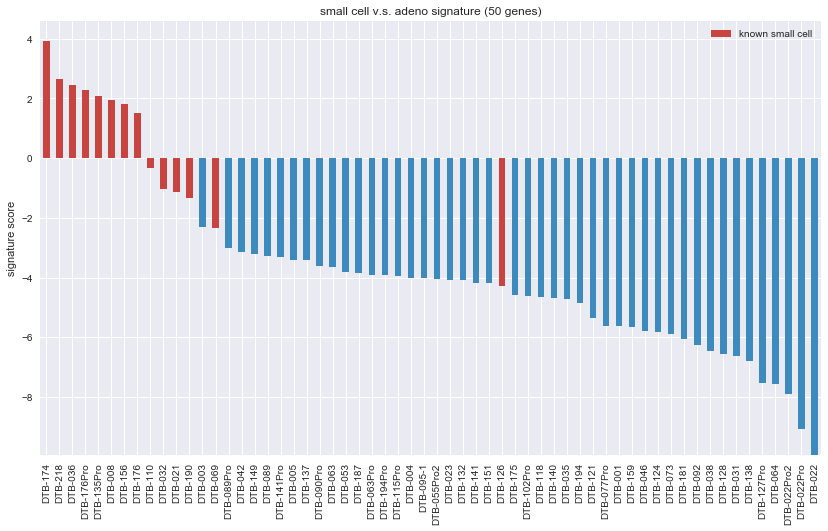

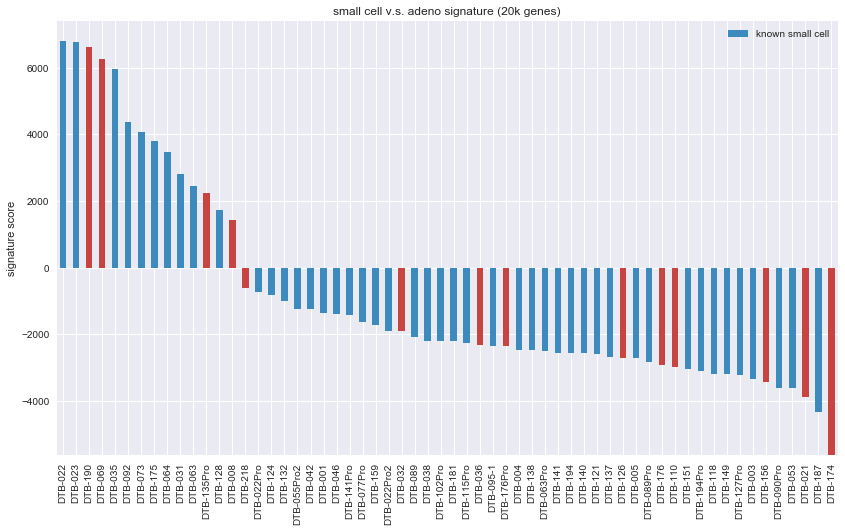

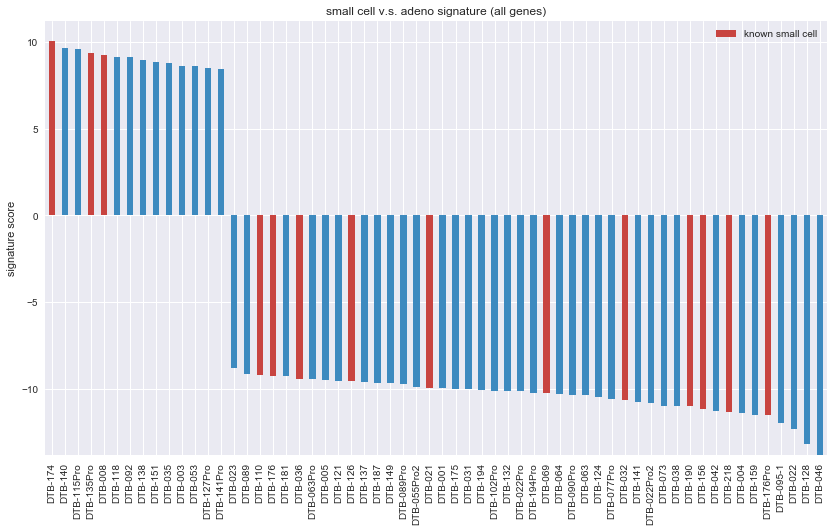

In [87]:
# apply NEPC signatures to known samples
X, y = data_prep()
sig_df = pd.read_pickle("./data/NEPC/NEPC_sigs.pkl")
sig_scores_df = pd.DataFrame(index=X.index) 

for sig in sig_df.columns:
    fig = plt.figure(sig, figsize=(14,8))
    sig_scores_df[sig] = np.matmul(X.as_matrix(), sig_df[sig])
    sig_scores_df.sort_values(sig, ascending=False, inplace=True)
    
    small_cell = list(y[y["NEPC_label"] == 1].index)
    adeno = list(y[y["NEPC_label"] != 1].index)
    colors = dict(zip(small_cell + adeno, ["#C84440"] * len(small_cell) + ["#3D8ABF"] * len(adeno)))
    
    sig_scores_df[sig].plot.bar(color=[colors[i] for i in sig_scores_df.index])
    plt.title("small cell v.s. adeno signature ({0} genes)".format(sig))
    plt.ylabel("signature score")
    plt.legend(["known small cell"])
    fig.savefig("./{0}_gene_scores.png".format(sig), dpi=200)

plt.show()

### Heatmap with 50 gene signature

In [6]:
def median_centering(df):
    """ gene-wise median centering """
    medians = df.median(axis=1)
    for i in df.index:
        df.loc[i] = df.loc[i] - medians[i]
    return df

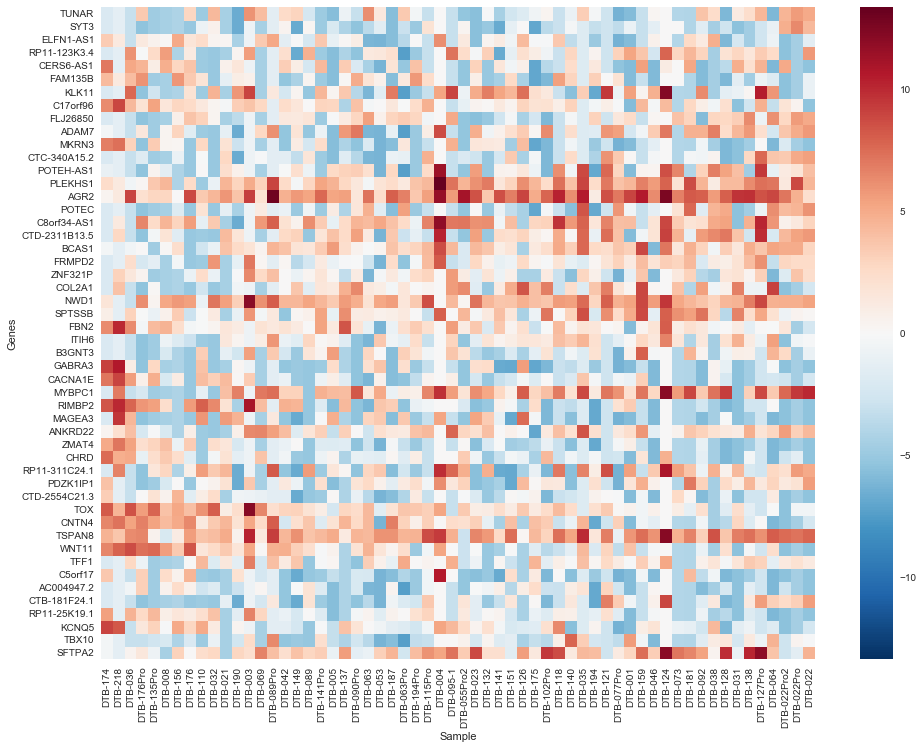

In [81]:
X50 = median_centering(X[sig_df[sig_df["50"]!=0].index].copy())
sig_scores_df50 = sig_scores_df[sig_scores_df["50"]!=0].copy()
sample_order = list(sig_scores_df50.sort_values("50", ascending=False).index)
X50 = X50.loc[sample_order]
X50 = X50.transpose()

fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.heatmap(X50, ax=ax, center=0)
ax.set_ylabel("Genes")
ax.set_xlabel("Sample")
fig.savefig("./nice.png", dpi=300)
plt.show()

### Make change to one plot based on Joshi's request (June-9-2017)

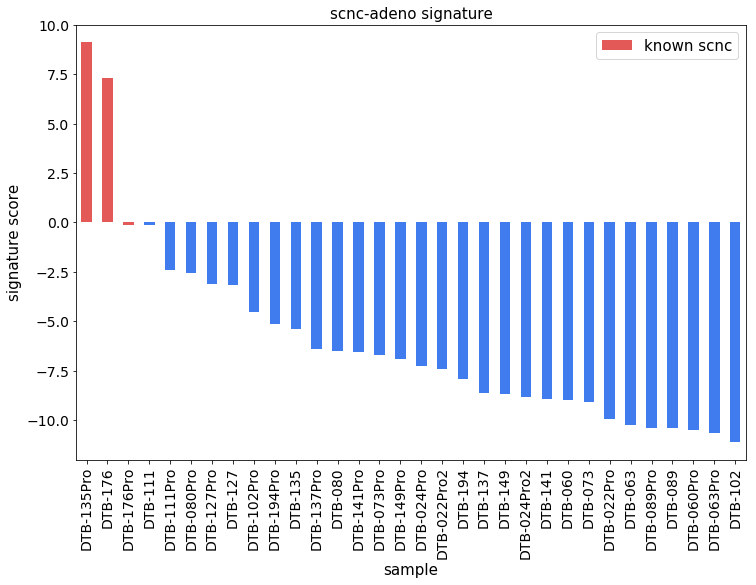

In [100]:
### add "DTB-176Pro" to scnc label

plt.figure(figsize=(9,5))
this_sig = df_combined[["scnc-adeno", "TimePoint", "NEPC_label"]].copy().sort_values(by="scnc-adeno", ascending=False)
this_sig.set_value("DTB-176Pro", "NEPC_label", "scnc") ####### Here is the real change

highlight = list(this_sig[this_sig["NEPC_label"] == "scnc"].index)
rest = list(this_sig[this_sig["NEPC_label"] != "scnc"].index)
colors = dict(zip(highlight + rest, ["#E35957"] * len(highlight) + ["#407CED"] * len(rest)))

this_sig["scnc-adeno"].plot.bar(color=[colors[i] for i in this_sig.index], figsize=(12,8), fontsize=14)

plt.title("scnc-adeno" + " signature", fontsize=15)
plt.ylabel("signature score", fontsize=15)
plt.ylim((-12,10))
plt.xlabel("sample", fontsize=15)
plt.legend(["known " + "scnc"], fontsize=15)

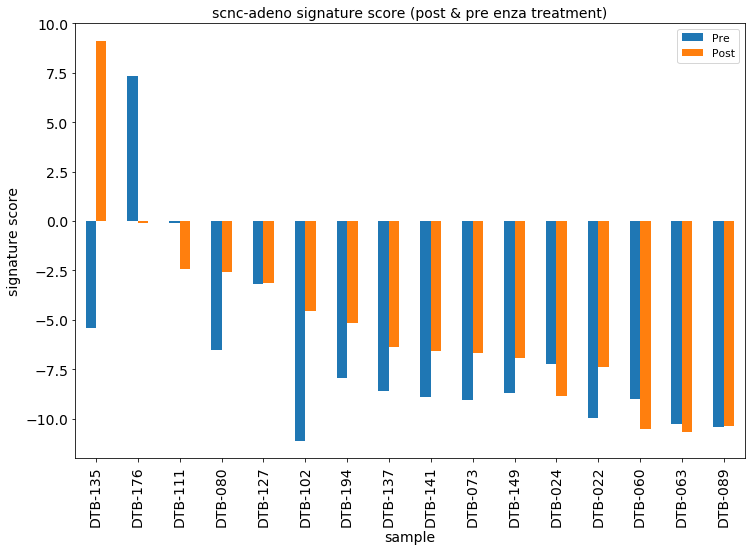

In [99]:
### plot same graph with sample post-pre values side by side
def extract_sample_name(name):
    if name.endswith("Pro"):
        return name[:-3]
    elif name.endswith("Pro2"):
        return name[:-4]
    else:
        assert(name[-1] in "0123456789")
        return name

sample_pair = pd.read_csv("./data/WCDT_paired_samples.tab", delimiter="\t", index_col="Sample")
assert(sorted(list(sample_pair.index))==sorted(list(this_sig.index)))
sample_pair_dict = dict(zip(sample_pair.index, sample_pair['TimePoint']))
this_sig_pair = pd.DataFrame(columns=["Pre", "Post"])
for index, row in this_sig.iterrows():
    sample_name = extract_sample_name(index)
    sample_type = sample_pair_dict[index]
    this_sig_pair.set_value(sample_name, sample_type, row["scnc-adeno"])

this_sig_pair.plot.bar(figsize=(12,8), fontsize=14)
plt.title("scnc-adeno signature score (post & pre enza treatment)", fontsize=14)
plt.ylabel("signature score", fontsize=14)
plt.ylim((-12,10))
plt.xlabel("sample", fontsize=14)

In [72]:
cmap = matplotlib.cm.get_cmap('Spectral')

rgba = cmap(0.5)

In [76]:
Color(rgb=rgba[:3])

<Color #ffffbe>

In [75]:
rgba[:3]

(0.99807766243752405, 0.99923106497500958, 0.74602076124567474)